In [1]:
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision.transforms import transforms
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
batch_size = 100
img_height = 224
img_width = 224


In [3]:
training_dataset = tf.keras.utils.image_dataset_from_directory(directory="data/data/train",
                                                               labels="inferred",
                                                               label_mode="categorical",
                                                               color_mode="rgb",
                                                               validation_split=0.2,
                                                               subset="training",
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

validation_dataset = tf.keras.utils.image_dataset_from_directory(directory="data/data/train",
                                                                labels="inferred",
                                                                label_mode="categorical",
                                                                color_mode="rgb",
                                                                validation_split=0.2,
                                                                subset="validation",
                                                                seed=123,
                                                                image_size=(img_height, img_width),
                                                                batch_size=batch_size)

test_dataset = tf.keras.utils.image_dataset_from_directory(directory="data/data/test",
                                                            labels="inferred",
                                                            label_mode="categorical",
                                                            color_mode="rgb",
                                                            image_size=(img_height, img_width),
                                                            batch_size = 100)




Found 5216 files belonging to 3 classes.
Using 4173 files for training.
Found 5216 files belonging to 3 classes.
Using 1043 files for validation.
Found 624 files belonging to 3 classes.


In [4]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
augmented = tf.keras.layers.RandomFlip("horizontal")(inputs)
augmented = tf.keras.layers.RandomRotation(0.2)(augmented)
rescale = tf.keras.layers.Rescaling(1./255)(augmented)

base_model = tf.keras.applications.MobileNetV2(input_tensor=rescale,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

pooling = tf.keras.layers.GlobalMaxPooling2D()(base_model.layers[-1].output)
dropout = tf.keras.layers.Dropout(0.2)(pooling)

# dense_output = dropout
# for i in range(2):
#     dense_output =  tf.keras.layers.Dense(8, activation="relu")(dense_output)


final_output = tf.keras.layers.Dense(3, activation="softmax")(dropout)
model = tf.keras.models.Model(inputs=inputs, outputs=final_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip (RandomFlip)       (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 random_rotation (RandomRotatio  (None, 224, 224, 3)  0          ['random_flip[0][0]']            
 n)                                                                                               
                                                                                              

In [5]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy','Precision','Recall','AUC'])

In [6]:
n_epochs=5
history = model.fit(training_dataset,
                    epochs=n_epochs,
                    validation_data=validation_dataset)


Epoch 1/5
42/42 [==============================] - 205s 4s/step - loss: 2.7125 - accuracy: 0.4623 - precision: 0.4629 - recall: 0.4520 - auc: 0.6306 - val_loss: 1.0964 - val_accuracy: 0.6117 - val_precision: 0.6238 - val_recall: 0.5992 - val_auc: 0.8017
Epoch 2/5
42/42 [==============================] - 157s 4s/step - loss: 1.5765 - accuracy: 0.5912 - precision: 0.5966 - recall: 0.5823 - auc: 0.7671 - val_loss: 0.9183 - val_accuracy: 0.6961 - val_precision: 0.7030 - val_recall: 0.6807 - val_auc: 0.8585
Epoch 3/5
42/42 [==============================] - 138s 3s/step - loss: 1.3656 - accuracy: 0.6278 - precision: 0.6324 - recall: 0.6199 - auc: 0.8037 - val_loss: 0.7880 - val_accuracy: 0.6894 - val_precision: 0.6969 - val_recall: 0.6769 - val_auc: 0.8704
Epoch 4/5
42/42 [==============================] - 147s 3s/step - loss: 1.1948 - accuracy: 0.6552 - precision: 0.6590 - recall: 0.6487 - auc: 0.8307 - val_loss: 0.7310 - val_accuracy: 0.7105 - val_precision: 0.7179 - val_recall: 0.6980 - 

Text(0.5, 1.0, 'Training and validation accuracy')

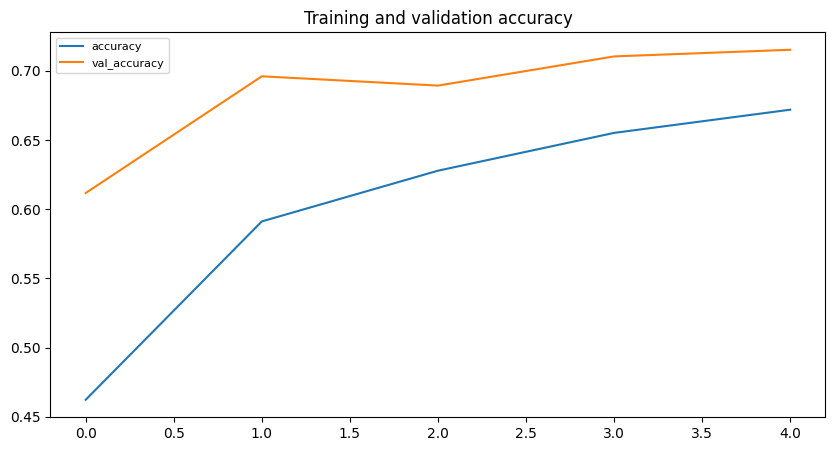

In [7]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(10,5))
plt.plot(history_df["accuracy"], label="accuracy")
plt.plot(history_df["val_accuracy"], label='val_accuracy')
plt.legend(["accuracy", "val_accuracy"], loc="upper left", prop={"size": 8})
plot_name = f"Training and validation accuracy"
plt.title(plot_name)


Text(0.5, 1.0, 'Training and validation precision')

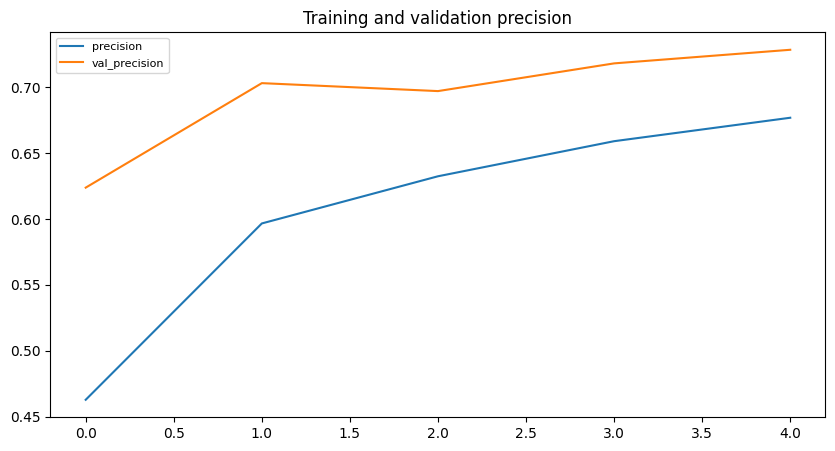

In [8]:
plt.figure(figsize=(10,5))
plt.plot(history_df["precision"], label="precision")
plt.plot(history_df["val_precision"], label='val_precision')
plt.legend(["precision", "val_precision"], loc="upper left", prop={"size": 8})
plot_name = f"Training and validation precision"
plt.title(plot_name)

Text(0.5, 1.0, 'Training and validation recall')

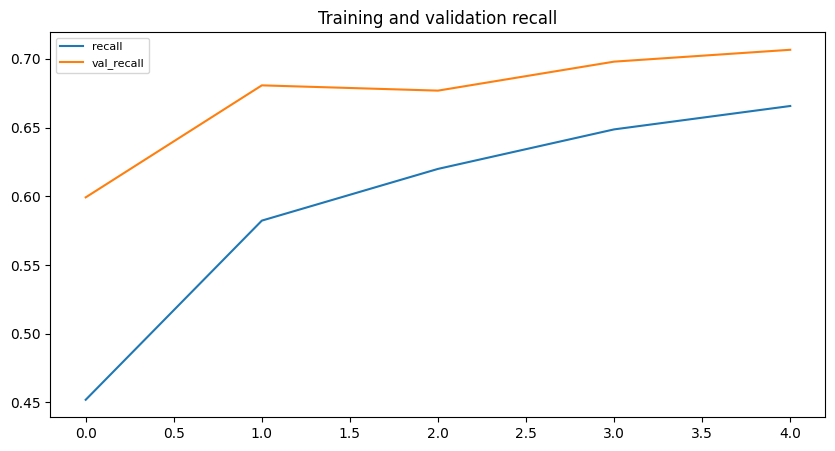

In [9]:
plt.figure(figsize=(10,5))
plt.plot(history_df["recall"], label="recall")
plt.plot(history_df["val_recall"], label='val_recall')
plt.legend(["recall", "val_recall"], loc="upper left", prop={"size": 8})
plot_name = f"Training and validation recall"
plt.title(plot_name)

In [10]:
history_df

,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc
0,2.712541,0.462257,0.462936,0.451953,0.630592,1.096365,0.611697,0.623752,0.599233,0.801654
1,1.576515,0.591181,0.596612,0.582315,0.767144,0.918313,0.696069,0.702970,0.680729,0.858536
2,1.365621,0.627846,0.632364,0.619938,0.803735,0.788049,0.689358,0.696940,0.676894,0.870444
3,1.194771,0.655164,0.658958,0.648694,0.830660,0.730971,0.710451,0.717949,0.697987,0.885744
4,1.108121,0.671939,0.676736,0.665708,0.841651,0.740837,0.715244,0.728261,0.706616,0.886176


In [11]:
model.evaluate(test_dataset)

7/7 [==============================] - 16s 2s/step - loss: 0.8425 - accuracy: 0.7163 - precision: 0.7304 - recall: 0.7035 - auc: 0.8670


[0.8424708843231201,
 0.7163461446762085,
 0.7304492592811584,
 0.7035256624221802,
 0.8670173287391663]

In [12]:
for x, y in test_dataset:
    print(x.shape)

(100, 224, 224, 3)
(100, 224, 224, 3)
(100, 224, 224, 3)
(100, 224, 224, 3)
(100, 224, 224, 3)
(100, 224, 224, 3)
(24, 224, 224, 3)


In [13]:
for x, y in test_dataset:
    print(y.shape)

(100, 3)
(100, 3)
(100, 3)
(100, 3)
(100, 3)
(100, 3)
(24, 3)


In [14]:
y.numpy().argmax(axis=1)

array([1, 0, 1, 0, 1, 0, 0, 2, 0, 1, 1, 0, 0, 1, 1, 1, 0, 2, 0, 2, 0, 2,
       0, 0], dtype=int64)

In [15]:
for x, y in test_dataset:
    prediction_prob = model.predict(x)
    predictions = prediction_prob.argmax(axis=1)
    print(predictions.shape)

4/4 [==============================] - 4s 497ms/step
(100,)
4/4 [==============================] - 2s 516ms/step
(100,)
4/4 [==============================] - 2s 528ms/step
(100,)
4/4 [==============================] - 3s 564ms/step
(100,)
4/4 [==============================] - 2s 466ms/step
(100,)
4/4 [==============================] - 2s 459ms/step
(100,)
1/1 [==============================] - 1s 521ms/step
(24,)


In [16]:
prediction_prob.shape

(24, 3)

In [17]:
prediction_probs = np.empty((0,3), float)
prediction_probs = np.vstack([prediction_probs, prediction_prob])
prediction_probs.shape

(24, 3)

In [24]:
img_arrays = []
# prediction_probs = np.empty((0,3), float)
predictions = np.array([])
labels =  np.array([])
# labels_encoded = np.empty((0,3), int)
for x, y in test_dataset:
  img_arrays = img_arrays + tf.unstack(x)
  prediction_prob = model.predict(x)
  # prediction_probs = np.vstack([prediction_probs, prediction_prob])
  predictions = np.concatenate([predictions, prediction_prob.argmax(axis=1)])
  # labels_encoded = np.vstack([labels_encoded, y.numpy()])
  labels = np.concatenate([labels, y.numpy().argmax(axis=1)])

1/1 [==============================] - 1s 651ms/step


In [19]:
len(prediction_probs)

624

In [20]:
prediction_probs.shape

(624, 3)

In [21]:
prediction_probs

array([[1.73471440e-02, 9.77391481e-01, 5.26140956e-03],
       [4.34177369e-03, 9.65407491e-01, 3.02507915e-02],
       [4.10553388e-04, 9.97450292e-01, 2.13906076e-03],
       ...,
       [5.93178630e-01, 1.24226911e-02, 3.94398719e-01],
       [3.73019166e-02, 9.41745341e-01, 2.09527966e-02],
       [2.16748178e-01, 5.12433290e-01, 2.70818532e-01]])

In [57]:
len(img_arrays)

624

In [58]:
len(predictions)

624

In [34]:
predictions

array([1., 1., 1., 0., 0., 2., 1., 1., 2., 2., 0., 1., 0., 2., 0., 0., 1.,
       2., 2., 0., 0., 2., 1., 0., 2., 0., 0., 2., 0., 1., 2., 2., 1., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 1., 0., 2.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 2., 2., 1., 0., 0.,
       2., 2., 2., 1., 1., 0., 1., 1., 2., 1., 2., 0., 0., 0., 1., 1., 0.,
       1., 0., 1., 0., 0., 0., 2., 2., 0., 1., 0., 0., 2., 2., 2., 2., 2.,
       0., 2., 1., 2., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 1., 2., 0., 1., 1., 0., 1., 0., 0., 1., 2., 2., 1., 2., 1., 1.,
       1., 0., 2., 0., 2., 0., 0., 2., 0., 0., 1., 1., 2., 0., 2., 0., 0.,
       1., 0., 2., 2., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 2., 2., 0.,
       1., 0., 0., 1., 2., 0., 1., 2., 1., 2., 2., 0., 0., 1., 0., 0., 1.,
       1., 1., 2., 2., 0., 1., 2., 1., 2., 1., 0., 1., 0., 1., 0., 0., 0.,
       2., 2., 1., 2., 0., 1., 2., 0., 1., 0., 1., 0., 0., 2., 0., 2., 0.,
       0., 2., 1., 2., 0.

In [60]:
len(labels)

624

In [35]:
labels

array([1., 1., 1., 0., 1., 0., 1., 1., 0., 2., 2., 1., 0., 2., 0., 0., 1.,
       2., 2., 0., 1., 2., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 2.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 2.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 2., 2., 1., 1., 0., 1., 1., 2., 1., 0., 1., 2., 2., 1., 1., 0.,
       1., 0., 1., 2., 0., 0., 1., 2., 0., 1., 0., 0., 2., 1., 2., 2., 0.,
       0., 0., 1., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       1., 1., 2., 0., 1., 2., 0., 1., 1., 2., 1., 2., 2., 1., 2., 0., 1.,
       1., 0., 2., 1., 1., 2., 0., 2., 0., 0., 1., 0., 1., 0., 2., 0., 0.,
       1., 0., 2., 1., 2., 0., 0., 1., 0., 2., 0., 0., 0., 0., 2., 2., 0.,
       1., 0., 0., 1., 2., 0., 1., 2., 1., 2., 2., 0., 2., 1., 0., 2., 1.,
       1., 1., 0., 1., 0., 0., 2., 1., 2., 0., 2., 1., 0., 2., 0., 1., 1.,
       2., 2., 1., 2., 0., 1., 2., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
       2., 1., 0., 2., 0.

In [29]:
from sklearn.preprocessing import label_binarize

labels_binarized = label_binarize(labels, classes=list(range(len(test_dataset.class_names))))
predictions_binarized = label_binarize(predictions, classes=list(range(len(test_dataset.class_names))))

In [40]:

#https://stackoverflow.com/questions/63303682/sklearn-multiclass-roc-auc-score
from sklearn.metrics import roc_auc_score

roc_auc_score(labels_binarized, predictions_binarized, average = 'weighted', multi_class='ovr')

0.7889425121639473

In [41]:
test_outcomes_dict = {}
for i in range(len(test_dataset.class_names)):

    test_true_positives = np.where((labels == i) & (predictions == i))[0]
    test_false_positives = np.where((labels != i) & (predictions == i))[0]
    test_true_negatives = np.where((labels != i) & (predictions != i))[0]
    test_false_negatives = np.where((labels == i) & (predictions != i))[0]

    test_outcomes_dict[i] = {"True Positives":test_true_positives,
                            "False Positives": test_false_positives,
                            "True Negatives": test_true_negatives, 
                            "False Negatives": test_false_negatives}

In [42]:
bacteria = test_outcomes_dict[0]

sample_img_indexes = list(np.random.choice(bacteria["False Positives"], size=9))
sample_img_indexes

[540, 107, 157, 452, 352, 325, 442, 279, 503]

In [43]:
sample_test_img_arrays = [img_arrays[i] for i in sample_img_indexes]
sample_test_img_arrays

[<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[24.      , 24.      , 24.      ],
         [24.917412, 24.917412, 24.917412],
         [24.76556 , 24.76556 , 24.76556 ],
         ...,
         [31.      , 31.      , 31.      ],
         [31.497768, 31.497768, 31.497768],
         [29.15215 , 29.15215 , 29.15215 ]],
 
        [[28.      , 28.      , 28.      ],
         [26.082588, 26.082588, 26.082588],
         [26.      , 26.      , 26.      ],
         ...,
         [33.00631 , 33.00631 , 33.00631 ],
         [33.054222, 33.054222, 33.054222],
         [29.342518, 29.342518, 29.342518]],
 
        [[24.165176, 24.165176, 24.165176],
         [24.97768 , 24.97768 , 24.97768 ],
         [24.442612, 24.442612, 24.442612],
         ...,
         [30.51116 , 30.51116 , 30.51116 ],
         [28.123222, 28.123222, 28.123222],
         [31.51116 , 31.51116 , 31.51116 ]],
 
        ...,
 
        [[31.165176, 31.165176, 31.165176],
         [28.48877 , 28.48877 , 28.48877 ]

In [52]:
sample_test_img_arrays[1]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[218.50766  , 218.50766  , 218.50766  ],
        [214.39287  , 214.39287  , 214.39287  ],
        [210.92857  , 210.92857  , 210.92857  ],
        ...,
        [ 12.068878 ,  12.068878 ,  12.068878 ],
        [ 12.058672 ,  12.058672 ,  12.058672 ],
        [ 11.3648205,  11.3648205,  11.3648205]],

       [[217.55867  , 217.55867  , 217.55867  ],
        [216.39285  , 216.39285  , 216.39285  ],
        [211.96428  , 211.96428  , 211.96428  ],
        ...,
        [ 16.242323 ,  16.242323 ,  16.242323 ],
        [ 12.645394 ,  12.645394 ,  12.645394 ],
        [ 12.869904 ,  12.869904 ,  12.869904 ]],

       [[215.       , 215.       , 215.       ],
        [215.52806  , 215.52806  , 215.52806  ],
        [209.28572  , 209.28572  , 209.28572  ],
        ...,
        [ 31.808617 ,  31.808617 ,  31.808617 ],
        [ 16.464268 ,  16.464268 ,  16.464268 ],
        [ 10.747432 ,  10.747432 ,  10.747432 ]],

       ...,

     

In [44]:
sample_test_prediction_probabilities = [max(model.predict(np.expand_dims(img_array, axis=0))[0]) for img_array in sample_test_img_arrays]
sample_test_prediction_probabilities

1/1 [==============================] - 0s 69ms/step


[0.5540723,
 0.99655163,
 0.69127184,
 0.9940335,
 0.48565117,
 0.4986297,
 0.9127096,
 0.8374681,
 0.9495926]

In [45]:

sample_test_labels = [test_dataset.class_names[int(i)] for i in labels[sample_img_indexes]]
sample_test_labels


['NORMAL',
 'VIRUS',
 'VIRUS',
 'VIRUS',
 'VIRUS',
 'VIRUS',
 'NORMAL',
 'VIRUS',
 'VIRUS']

In [46]:

sample_test_predictions = [test_dataset.class_names[int(i)] for i in predictions[sample_img_indexes]]
sample_test_predictions



['BACTERIA',
 'BACTERIA',
 'BACTERIA',
 'BACTERIA',
 'BACTERIA',
 'BACTERIA',
 'BACTERIA',
 'BACTERIA',
 'BACTERIA']

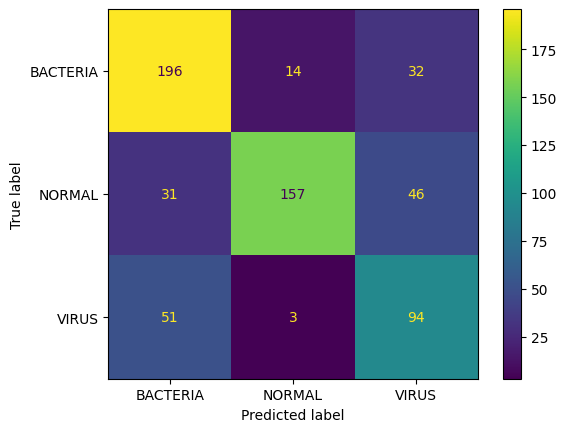

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(labels, predictions, labels=list(range(len(test_dataset.class_names))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot()
plt.show()

In [48]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape(persistent=True) as tape:
        last_conv_layer_output, preds = grad_model(img_array, training=False)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [49]:
last_conv_layer_name = list(filter(lambda x: isinstance(x, tf.keras.layers.Conv2D), model.layers))[-1].name
last_conv_layer_name

'Conv_1'

In [50]:
import matplotlib.cm as cm

img_array = img_arrays[0]
img_tensor = np.expand_dims(img_array, axis=0)

heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name)
heatmap = np.uint8(255 * heatmap)
heatmap

array([[ 47, 113, 171, 239, 151,  94,  43],
       [ 40,  75, 153, 253, 147,  92,  43],
       [  0,  41, 118, 255, 128,  59,  25],
       [  0,   0,  48, 162,  69,   0,   0],
       [  0,   0,   0,  49,   0,   0,   0],
       [  0,   0,   0,  14,   0,   0,   0],
       [  0,   0,   0,  24,   0,   0,   0]], dtype=uint8)

C:\Users\angus\AppData\Local\Temp\ipykernel_11896\2997964663.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


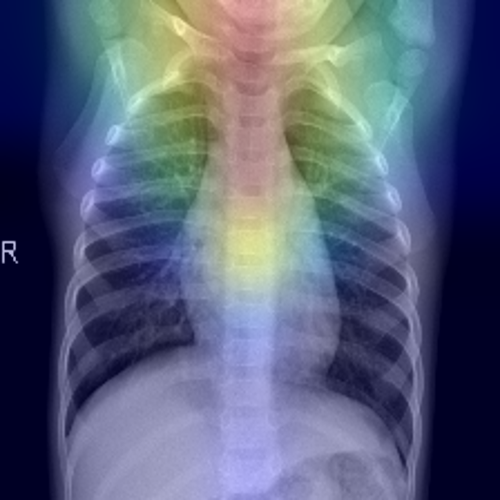

In [51]:
img_array = img_arrays[0]
img_tensor = np.expand_dims(img_array, axis=0)
heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name)
heatmap = np.uint8(255 * heatmap)
heatmap

# Create an image with RGB colorized heatmap
img_array_resized = tf.keras.preprocessing.image.array_to_img(img_array)
img_array_resized = img_array_resized.resize((500, 500))
img_array_resized = tf.keras.preprocessing.image.img_to_array(img_array_resized)


jet = cm.get_cmap("jet")
# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img_array_resized.shape[0], img_array_resized.shape[1]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img_array_resized
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
superimposed_img

In [107]:
img_array = np.expand_dims(img_arrays[0], axis=0)
prediction_probs = np.array(model.predict(img_array)[0])
prediction_prob = max(prediction_probs)
prediction = test_dataset.class_names[prediction_probs.argmax(axis=0)]
label = test_dataset.class_names[int(labels[0])]

print(prediction_probs, prediction_prob, prediction, label)

1/1 [==============================] - 0s 54ms/step
[0.86778116 0.12695163 0.00526722] 0.86778116 BACTERIA BACTERIA


1/1 [==============================] - 0s 54ms/step


C:\Users\angus\AppData\Local\Temp\ipykernel_22280\526016686.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


1/1 [==============================] - 0s 62ms/step


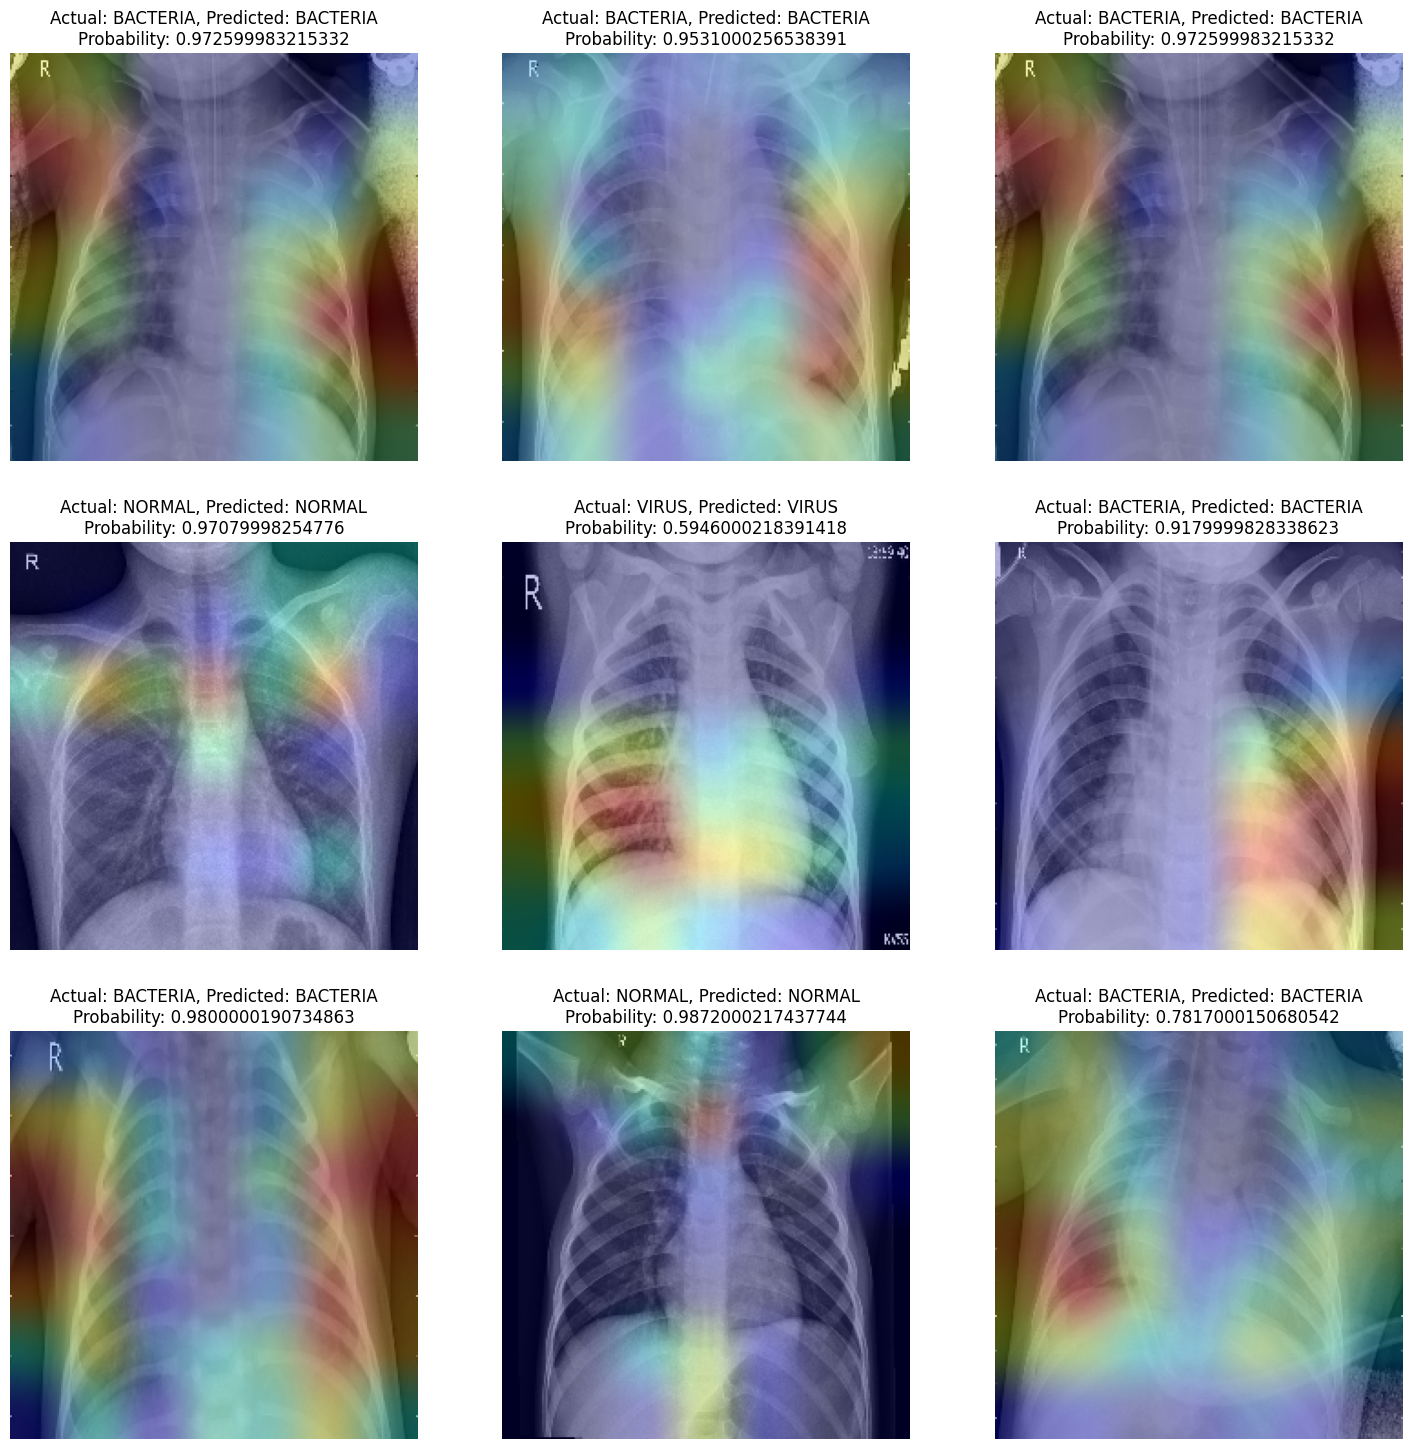

In [109]:
import matplotlib.cm as cm
random_img_arrays = np.random.randint(99, size=9)

fig, axes = plt.subplots(3,3, figsize=(18,18))

for i in range(len(random_img_arrays)):

    img_array = np.expand_dims(img_arrays[random_img_arrays[i]], axis=0)
    prediction_probs = np.array(model.predict(img_array)[0])
    prediction_prob = max(prediction_probs)
    prediction = test_dataset.class_names[prediction_probs.argmax(axis=0)]
    label = test_dataset.class_names[int(labels[random_img_arrays[i]])]

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[2]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + np.squeeze(img_array)
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    axes[i//3, i%3].imshow(superimposed_img)
    axes[i//3, i%3].set_title(f"Actual: {label}, Predicted: {prediction}\nProbability: {round(prediction_prob,4)}")
    axes[i//3, i%3].axis('off')

plt.show()

